To-Do list:
Read in dataset
Train-Validation-Test splitting
Clustering
Plotting that
Read the paper from exercise 5 (CNN)
Implement CNN to identify motifs of the polymers

## Importing and splitting the data

In [ ]:
import csv
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

Import the dataset

In [ ]:
csvfile = 'polymers_dataset.csv'
rows = []
fingerprints = []
nonzero_count = 0
with open(csvfile, 'r') as csv_file:
     csv_reader = csv.reader(csv_file, dialect='excel', delimiter=',')
     line_count = 0
     for row in csv_reader:
          if line_count == 0:
               pass
          else:
               rows.append([val for val in row[:3]])
               fingerprints.append([int(val) for val in row[3:]])
          line_count += 1


Printing a certain index with data

In [ ]:
nonzero_count = 0
print('Number of polymers: ', len(rows))
index = 411 #Change this value to see the data
print(f"Index {rows[index][0]} with SMILES {rows[index][1]}")
print('Label: ', rows[index][2])
print('Fingerprint: ',fingerprints[index])
for i in range(2048):
     if fingerprints[index][i] != 0:
          nonzero_count += 1
print('Fingerprints == 1: ', nonzero_count)

Splitting the data into training, validation and testing data

In [ ]:
line_count = len(rows)
indices = np.arange(line_count)
indices_fin = np.arange(len(fingerprints))
np.random.shuffle(indices)
split_train = 80
split_validation = 10
split_test = 10
train_end = int(line_count * split_train / 100)
val_end = train_end + int(line_count * split_validation / 100)
train_end_fin = int(len(fingerprints) * split_train / 100)
val_end_fin = train_end_fin + int(len(fingerprints) * split_validation / 100)
# Split data
train = [rows[i] for i in indices[:train_end]]
validation = [rows[i] for i in indices[train_end:val_end]]
test = [rows[i] for i in indices[val_end:]]
# Fingerprint data
fin_train = [fingerprints[i] for i in indices_fin[:train_end_fin]]
fin_validation = [fingerprints[i] for i in indices_fin[train_end_fin:val_end_fin]]
fin_test = [fingerprints[i] for i in indices_fin[val_end_fin:]]
#Labels data
label_train = [train[i][2] for i in range(len(train))]
label_validation = [validation[i][2] for i in range(len(validation))]
label_test = [test[i][2] for i in range(len(test))]
#Change strings to integers
for i in range(len(label_train)):
    if label_train[i] == 'peptide':
        label_train[i] = 0
    if label_train[i] == 'plastic':
        label_train[i] = 1
    if label_train[i] == 'oligosaccharide':
        label_train[i] = 2
for i in range(len(label_validation)):
    if label_validation[i] == 'peptide':
        label_validation[i] = 0
    if label_validation[i] == 'plastic':
        label_validation[i] = 1
    if label_validation[i] == 'oligosaccharide':
        label_validation[i] = 2
for i in range(len(label_test)):
    if label_test[i] == 'peptide':
        label_test[i] = 0
    if label_test[i] == 'plastic':
        label_test[i] = 1
    if label_test[i] == 'oligosaccharide':
        label_test[i] = 2
print(len(train),len(validation),len(test),len(train)+len(validation)+len(test),len(rows))
print(test[len(test)-1])
print(label_validation)

Draw the selected molecule

In [ ]:
mol = Chem.MolFromSmiles(train[index][1])
mol

Calculate the probabilities of the 3 labels

In [ ]:
sugar = 0
plastic = 0
peptide = 0

for i in range(len(rows)):
    if rows[i][2] == 'peptide':
        peptide += 1
    elif rows[i][2] == 'plastic':
        plastic += 1
    elif rows[i][2] == 'oligosaccharide':
        sugar += 1

p_sugar = sugar / len(rows)
p_plastic = plastic / len(rows)
p_peptide = peptide / len(rows)
print(f"Probability of peptide, plastic or sugar for the label: {p_peptide:6.3f}, {p_plastic:6.3f}, {p_sugar:6.3f}.")
print('Total probability: ',p_sugar+p_plastic+p_peptide)


## Make a Neural network to identify polymers

Importing libraries

In [ ]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

Prepare the data for the training, validation and testing data sets

In [ ]:
batch_sz = 256
train_dataloader = torch.utils.data.DataLoader(list(zip(fin_train, label_train)), batch_size=batch_sz, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(list(zip(fin_validation, label_validation)), batch_size=batch_sz, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(fin_test, label_test)), batch_size=batch_sz, shuffle=True)

In [ ]:
print(train_dataloader)

Make the model with three layers: the 2048 fingerprints to a 128 hidden layer, then that layer goes to a 16 layer and then the last gives the 3 labels. The activation function used are ReLu and softmax.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
            super(Model, self).__init__()
            self.layer1 = torch.nn.Linear(2048, 128)
            self.layer2 = torch.nn.Linear(128, 16)
            self.layer3 = torch.nn.Linear(16, 3)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.transpose(0,1)
        x = x.to(self.layer1.weight.dtype)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

Settings for the Neural Network such as the criterion, optimizer, number of epochs

In [66]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
no_epochs = 50
train_loss = list()
val_loss = list()
best_val_loss = 1
#fingerprints_tensor = []
##for fp in fingerprints:
#    fp_tensor = fp.clone().detach()
#    fingerprints_tensor.append(fp_tensor)
#fingerprints = torch.stack(fingerprints_tensor)

Training and validation loop

In [67]:
for epoch in range(no_epochs):

    total_train_loss = 0
    model.train()
    # training loop
    for itr, (fingerprints, labels) in enumerate(train_dataloader):
      #  if len(fingerprints) != batch_sz or len(labels) != batch_sz:
       #     continue  # exclude incomplete batch

        if (torch.cuda.is_available()):
            model.cuda()
            fingerprints = fingerprints.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        fingerprints_tensor = []
        for fp in fingerprints:
            fp_tensor = fp.clone().detach()
            fingerprints_tensor.append(fp_tensor)
        fingerprints = torch.stack(fingerprints_tensor)

        fingerprints = fingerprints.to(model.layer1.weight.dtype)
        model.to(torch.float32)

        pred = model(fingerprints)

        loss = criterion(pred, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    total_val_loss = 0
    total = 0
    model.eval()
    with torch.no_grad():
        # validation loop
        for itr, (fingerprints, labels) in enumerate(val_dataloader):

            if (torch.cuda.is_available()):
                model.cuda()
                fingerprints = fingerprints.cuda()
                labels = labels.cuda()

            fingerprints_tensor = []
            for fp in fingerprints:
                fp_tensor = fp.clone().detach()
                fingerprints_tensor.append(fp_tensor)
            fingerprints = torch.stack(fingerprints_tensor)

            pred = model(fingerprints)

            loss = criterion(pred, labels)
            total_val_loss += loss.item()

            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

    accuracy = total / len(val_dataloader.dataset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")


Epoch: 1/50, Train Loss: 1.09935146, Val Loss: 1.09932563, Val Accuracy: 0.32427184

Epoch: 2/50, Train Loss: 1.09834530, Val Loss: 1.09873671, Val Accuracy: 0.32912621

Epoch: 3/50, Train Loss: 1.09743717, Val Loss: 1.09839307, Val Accuracy: 0.32718447


KeyboardInterrupt: 

To-Do list:
Read in dataset
Train-Validation-Test splitting
Clustering
Plotting that
Read the paper from exercise 5 (CNN)
Implement CNN to identify motifs of the polymers

## Importing and splitting the data

In [ ]:
import csv
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

Import the dataset

In [ ]:
csvfile = 'polymers_dataset.csv'
rows = []
fingerprints = []
nonzero_count = 0
with open(csvfile, 'r') as csv_file:
     csv_reader = csv.reader(csv_file, dialect='excel', delimiter=',')
     line_count = 0
     for row in csv_reader:
          if line_count == 0:
               pass
          else:
               rows.append([val for val in row[:3]])
               fingerprints.append([int(val) for val in row[3:]])
          line_count += 1


Printing a certain index with data

In [ ]:
nonzero_count = 0
print('Number of polymers: ', len(rows))
index = 411 #Change this value to see the data
print(f"Index {rows[index][0]} with SMILES {rows[index][1]}")
print('Label: ', rows[index][2])
print('Fingerprint: ',fingerprints[index])
for i in range(2048):
     if fingerprints[index][i] != 0:
          nonzero_count += 1
print('Fingerprints == 1: ', nonzero_count)

Splitting the data into training, validation and testing data

In [ ]:
line_count = len(rows)
indices = np.arange(line_count)
indices_fin = np.arange(len(fingerprints))
np.random.shuffle(indices)
split_train = 80
split_validation = 10
split_test = 10
train_end = int(line_count * split_train / 100)
val_end = train_end + int(line_count * split_validation / 100)
train_end_fin = int(len(fingerprints) * split_train / 100)
val_end_fin = train_end_fin + int(len(fingerprints) * split_validation / 100)
# Split data
train = [rows[i] for i in indices[:train_end]]
validation = [rows[i] for i in indices[train_end:val_end]]
test = [rows[i] for i in indices[val_end:]]
# Fingerprint data
fin_train = [fingerprints[i] for i in indices_fin[:train_end_fin]]
fin_validation = [fingerprints[i] for i in indices_fin[train_end_fin:val_end_fin]]
fin_test = [fingerprints[i] for i in indices_fin[val_end_fin:]]
#Labels data
label_train = [train[i][2] for i in range(len(train))]
label_validation = [validation[i][2] for i in range(len(validation))]
label_test = [test[i][2] for i in range(len(test))]
#Change strings to integers
for i in range(len(label_train)):
    if label_train[i] == 'peptide':
        label_train[i] = 0
    if label_train[i] == 'plastic':
        label_train[i] = 1
    if label_train[i] == 'oligosaccharide':
        label_train[i] = 2
for i in range(len(label_validation)):
    if label_validation[i] == 'peptide':
        label_validation[i] = 0
    if label_validation[i] == 'plastic':
        label_validation[i] = 1
    if label_validation[i] == 'oligosaccharide':
        label_validation[i] = 2
for i in range(len(label_test)):
    if label_test[i] == 'peptide':
        label_test[i] = 0
    if label_test[i] == 'plastic':
        label_test[i] = 1
    if label_test[i] == 'oligosaccharide':
        label_test[i] = 2
print(len(train),len(validation),len(test),len(train)+len(validation)+len(test),len(rows))
print(test[len(test)-1])
print(label_validation)

Draw the selected molecule

In [ ]:
mol = Chem.MolFromSmiles(train[index][1])
mol

Calculate the probabilities of the 3 labels

In [ ]:
sugar = 0
plastic = 0
peptide = 0

for i in range(len(rows)):
    if rows[i][2] == 'peptide':
        peptide += 1
    elif rows[i][2] == 'plastic':
        plastic += 1
    elif rows[i][2] == 'oligosaccharide':
        sugar += 1

p_sugar = sugar / len(rows)
p_plastic = plastic / len(rows)
p_peptide = peptide / len(rows)
print(f"Probability of peptide, plastic or sugar for the label: {p_peptide:6.3f}, {p_plastic:6.3f}, {p_sugar:6.3f}.")
print('Total probability: ',p_sugar+p_plastic+p_peptide)


## Make a Neural network to identify polymers

Importing libraries

In [ ]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

Prepare the data for the training, validation and testing data sets

In [ ]:
batch_sz = 256
train_dataloader = torch.utils.data.DataLoader(list(zip(fin_train, label_train)), batch_size=batch_sz, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(list(zip(fin_validation, label_validation)), batch_size=batch_sz, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(fin_test, label_test)), batch_size=batch_sz, shuffle=True)

In [ ]:
print(train_dataloader)

Make the model with three layers: the 2048 fingerprints to a 128 hidden layer, then that layer goes to a 16 layer and then the last gives the 3 labels. The activation function used are ReLu and softmax.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
            super(Model, self).__init__()
            self.layer1 = torch.nn.Linear(2048, 128)
            self.layer2 = torch.nn.Linear(128, 16)
            self.layer3 = torch.nn.Linear(16, 3)
            self.relu = torch.nn.ReLU()
            self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.transpose(0,1)
        x = x.to(self.layer1.weight.dtype)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

Settings for the Neural Network such as the criterion, optimizer, number of epochs

In [ ]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
no_epochs = 50
train_loss = list()
val_loss = list()
best_val_loss = 1
#fingerprints_tensor = []
##for fp in fingerprints:
#    fp_tensor = fp.clone().detach()
#    fingerprints_tensor.append(fp_tensor)
#fingerprints = torch.stack(fingerprints_tensor)

Training and validation loop

In [ ]:
for epoch in range(no_epochs):

    total_train_loss = 0
    model.train()
    # training loop
    for itr, (fingerprints, labels) in enumerate(train_dataloader):
      #  if len(fingerprints) != batch_sz or len(labels) != batch_sz:
       #     continue  # exclude incomplete batch

        if (torch.cuda.is_available()):
            model.cuda()
            fingerprints = fingerprints.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        fingerprints_tensor = []
        for fp in fingerprints:
            fp_tensor = fp.clone().detach()
            fingerprints_tensor.append(fp_tensor)
        fingerprints = torch.stack(fingerprints_tensor)

        fingerprints = fingerprints.to(model.layer1.weight.dtype)
        model.to(torch.float32)

        pred = model(fingerprints)

        loss = criterion(pred, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    total_val_loss = 0
    total = 0
    model.eval()
    with torch.no_grad():
        # validation loop
        for itr, (fingerprints, labels) in enumerate(val_dataloader):

            if (torch.cuda.is_available()):
                model.cuda()
                fingerprints = fingerprints.cuda()
                labels = labels.cuda()

            fingerprints_tensor = []
            for fp in fingerprints:
                fp_tensor = fp.clone().detach()
                fingerprints_tensor.append(fp_tensor)
            fingerprints = torch.stack(fingerprints_tensor)

            pred = model(fingerprints)

            loss = criterion(pred, labels)
            total_val_loss += loss.item()

            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

    accuracy = total / len(val_dataloader.dataset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")


Epoch: 1/50, Train Loss: 1.09913078, Val Loss: 1.10078565, Val Accuracy: 0.32669903

Epoch: 2/50, Train Loss: 1.09825389, Val Loss: 1.09997578, Val Accuracy: 0.34417476

Epoch: 3/50, Train Loss: 1.09741922, Val Loss: 1.09897090, Val Accuracy: 0.33883495

Epoch: 4/50, Train Loss: 1.09657832, Val Loss: 1.09777810, Val Accuracy: 0.34126214

Epoch: 5/50, Train Loss: 1.09533599, Val Loss: 1.09888838, Val Accuracy: 0.32233010

Epoch: 6/50, Train Loss: 1.09405732, Val Loss: 1.09843704, Val Accuracy: 0.32184466

Epoch: 7/50, Train Loss: 1.09250854, Val Loss: 1.10157899, Val Accuracy: 0.33834951

Epoch: 8/50, Train Loss: 1.09056739, Val Loss: 1.09816020, Val Accuracy: 0.32718447

Epoch: 9/50, Train Loss: 1.08818229, Val Loss: 1.09999976, Val Accuracy: 0.32621359

Epoch: 10/50, Train Loss: 1.08542917, Val Loss: 1.10194707, Val Accuracy: 0.33495146

Epoch: 11/50, Train Loss: 1.08218492, Val Loss: 1.10038673, Val Accuracy: 0.33543689

Epoch: 12/50, Train Loss: 1.07851610, Val Loss: 1.09835667, Va

KeyboardInterrupt: 

Printing the training and validation loss over number of epochs

In [ ]:
fig=plt.figure(figsize=(15, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Training loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
#here goes in PCA code
#will add in later

Printing the training and validation loss over number of epochs

In [ ]:
fig=plt.figure(figsize=(15, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Training loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
#here goes in PCA code
#will add in later

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
data = pd.read_csv('polymers_dataset.csv')
#Select predictor variables
X = data.iloc[:,3:].values

#Transform target variable using OneHotEncoder()
ohe = OneHotEncoder()

y_one_hot = ohe.fit_transform(np.array(data['label']).reshape(-1,1)).toarray()

#Create train and test sets, using 20% of the data for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state=0)
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Sequential

# Neural network
model = Sequential()
model.add(Dense(128, input_dim=2048, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

#Summarize and compile model
model.summary()
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


/home/djkeizer/anaconda3/envs/ml4chem/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/djkeizer/anaconda3/envs/ml4chem/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/djkeizer/anaconda3/envs/ml4chem/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/djkeizer/anaconda3/envs/ml4chem

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 264,387
Trainable params: 264,387
Non-trainable params: 0
_________________________________________________________________
Train on 16487 samples, validate on 4122 samples


2023-04-26 21:30:03.279992: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2023-04-26 21:30:03.330526: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3201000000 Hz
2023-04-26 21:30:03.332569: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x366ca80 executing computations on platform Host. Devices:
2023-04-26 21:30:03.332641: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-04-26 21:30:03.411360: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via T

Epoch 1/50
16487/16487 [==============================] - 1s 38us/sample - loss: 0.0217 - acc: 0.9961 - val_loss: 2.8722e-04 - val_acc: 1.0000
Epoch 2/50
16487/16487 [==============================] - 0s 28us/sample - loss: 1.3068e-04 - acc: 1.0000 - val_loss: 1.0436e-04 - val_acc: 1.0000
Epoch 3/50
16487/16487 [==============================] - 0s 28us/sample - loss: 5.1362e-05 - acc: 1.0000 - val_loss: 5.6608e-05 - val_acc: 1.0000
Epoch 4/50
16487/16487 [==============================] - 0s 28us/sample - loss: 2.7141e-05 - acc: 1.0000 - val_loss: 3.6455e-05 - val_acc: 1.0000
Epoch 5/50
16487/16487 [==============================] - 0s 27us/sample - loss: 1.6568e-05 - acc: 1.0000 - val_loss: 2.5895e-05 - val_acc: 1.0000
Epoch 6/50
16487/16487 [==============================] - 0s 26us/sample - loss: 1.1032e-05 - acc: 1.0000 - val_loss: 1.9464e-05 - val_acc: 1.0000
Epoch 7/50
16487/16487 [==============================] - 0s 28us/sample - loss: 7.7894e-06 - acc: 1.0000 - val_loss: 1.52

Text(0.5, 1.0, 'Confusion Matrix-Neural Network')

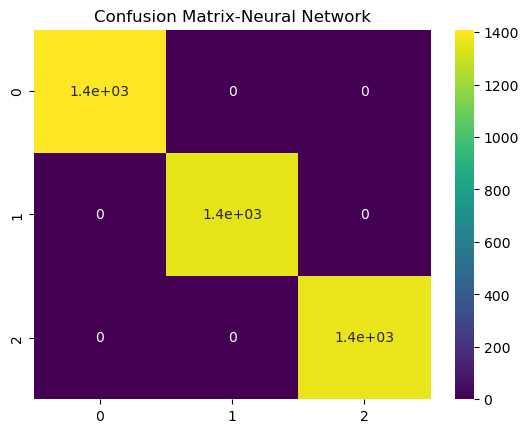

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Compute predicted values
prediction = model.predict(X_test).round()

#We create a function to transform the one-hot encoded arrays into an array of single values
def decoder(values):
  
  '''This function takes a vector of one-hot encoded arrays and returns
  the index of the corresponding object (0, 1 or 2)'''
    
  decoded = []

  for i in values:
    x = np.argmax(i)
    decoded.append(x)
  
  return decoded
  

predicted = decoder(prediction)

real = decoder(y_test)

#Create confusion matrix
conf = confusion_matrix(predicted, real)

sns.heatmap(conf, annot=True, cmap = 'viridis')
plt.title('Confusion Matrix-Neural Network')

In [5]:
from sklearn.ensemble import RandomForestClassifier

#Create Random Forest
rf = RandomForestClassifier(random_state=0)

#Train Random Forest
rf.fit(X_train, y_train)

#Compute Random Forest accuracy
score = rf.score(X_test, y_test)

print('Random Forest accuracy: {0}'.format(score))

Random Forest accuracy: 1.0


Text(0.5, 1.0, 'Confusion matrix-Random Forest')

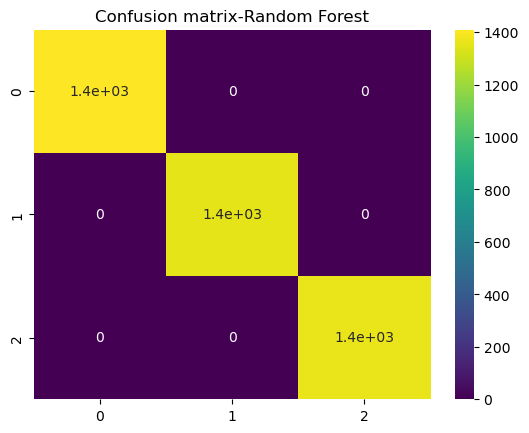

In [6]:
rf_prediction = decoder(rf.predict(X_test))

rf_true = decoder(y_test)

cm = confusion_matrix(rf_prediction, rf_true)

sns.heatmap(cm, annot=True, cmap = 'viridis')

plt.title('Confusion matrix-Random Forest')

In [3]:
from sklearn.decomposition import PCA
import seaborn as sns

#Create PCA with 2 components
pca = PCA(n_components=2)

#Reduce dimensions of the original set
coords = pca.fit_transform(X)

#Plot the groups using 
sns.scatterplot(coords[:,0], coords[:,1], hue=data['label'].values)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA clustering')

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given